In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import matplotlib
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation import received_power, quad_distribute_power, propagation_delay, map_rx_config, map_tx_config, \
                        gen_qrx_onlyclocked

from parametermeasurement import generate_clocks, measure_range_roberts, measure_bearing

from positioning import runningfix_directbearing_mle,  runningfix_directrange_mle

### Simulation preliminaries

In [2]:
weather     = 'clear' 
temperature = 298 # Kelvin
daynight    = 'night'

daynight_noise_factors = dict()
daynight_noise_factors['day_directsun']   = 1.000 # 5100 uA
daynight_noise_factors['day_indirectsun'] = 0.145 # 740 uA
daynight_noise_factors['night']           = 0.010 # very small

# minmax bounds to be safe if you set the noise factor yourself
bg_current = (np.minimum(1, np.maximum(0, daynight_noise_factors[daynight]))*5100)*1e-6;

weather_attenuation_factors = dict()
weather_attenuation_factors['clear'] = 0.0
weather_attenuation_factors['rain']  = -0.05
weather_attenuation_factors['fog']   = -0.2

atten = weather_attenuation_factors[weather];

In [3]:
a = np.load('optics/qrx_planoconvex.npz');
f_QRX, pd_snst, pd_gain, pd_dim, rx_P_rx_factor, rx_I_bg_factor, rx_thermal_factor1, rx_thermal_factor2 = map_rx_config(a);

In [4]:
a = np.load('optics/tx_lambertian_20deg_2W.npz')
tx_ha, tx_pwr, tx_norm, tx_lambertian_order = map_tx_config(a);

this factor is precomputed since it's the same for all links (/16 due to $C_i^2$ in the thermal_factor2, each cell gets 1/4 of the total cap)

In [5]:
# original bandwidth = 10 MHz, we assume a 100 kHz BPF here like bechadergue, effectively reducing BW by 100x 
#
# see noise variance equations for further info on this
bandwidth_scaling_due_to_filter = 0.01;
thermal_and_bg_curr = rx_I_bg_factor *  bandwidth_scaling_due_to_filter * bg_current + \
                      temperature    *( bandwidth_scaling_due_to_filter * rx_thermal_factor1 + \
                                      ( bandwidth_scaling_due_to_filter**3) * rx_thermal_factor2/16)

### Simulate propagation

In [6]:
#a = np.load('trajectories/generated_platooning.npz')

trajectory_partial_numsamples = 1000

L = 1.6 # [m]

xRL_to_rxL = np.concatenate((np.linspace(-1, 1, 500), np.linspace(1, 3, 500)  ))

yy = np.linspace(1,3, 500)**1.2
yRL_to_rxL = np.concatenate((np.linspace(5, 7, 500), yy+6 ))

ha = 5
hh = np.linspace(ha,4,500)
hdg = np.concatenate( (np.ones((500))*ha, hh) )

xRR_to_rxL = np.concatenate( (xRL_to_rxL[0:500] + L*np.cos(np.deg2rad(ha)) , xRL_to_rxL[500:] + L*np.cos(np.deg2rad(hh))) )
yRR_to_rxL = np.concatenate( (yRL_to_rxL[0:500] + L*np.sin(np.deg2rad(ha)) , yRL_to_rxL[500:] + L*np.sin(np.deg2rad(hh))) )

xRL_to_rxR = xRL_to_rxL - L
yRL_to_rxR = yRL_to_rxL
xRR_to_rxR = xRR_to_rxL - L
yRR_to_rxR = yRR_to_rxL

f_vehicle = 1e3;         # [Hz], trajectory simulation clock rate, fixed by trajectory generation
t_vehicle = 1/f_vehicle; # [s] , trajectory simulation clock period, fixed by trajectory generation

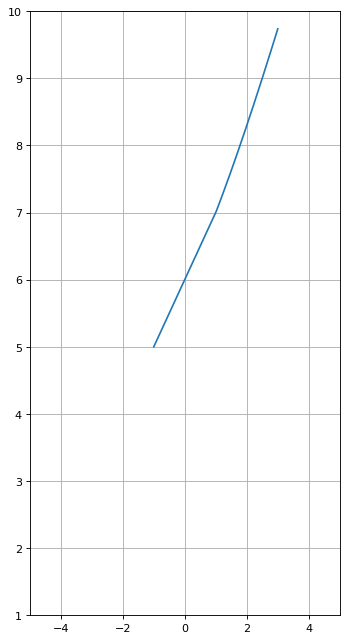

In [7]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
ax.plot(xRL_to_rxL, yRL_to_rxL)
ax.grid()
plt.xlim([-5,5.0])
plt.ylim([1.0,10.0])
plt.show()

In [8]:
localization_decimation_rate = 10
localization_rate = 1/(t_vehicle*localization_decimation_rate)
localization_num_steps = int(trajectory_partial_numsamples/localization_decimation_rate)
print("localization rate:", localization_rate, "Hz")
print("so each localization period considers", localization_decimation_rate, "trajectory samples")
print("and there are a total of", localization_num_steps, "steps")

localization rate: 100.0 Hz
so each localization period considers 10 trajectory samples
and there are a total of 100 steps


In [9]:
c         = 299702547 #299702547  # [m/s] speed of light
f_e       = 1.0e6;    # [Hz], emitted wave freq, left TX

f_adc_clock  = 1e7;             # [Hz], measurement clock freq
t_adc_clock  = 1/f_adc_clock;   # [s] , measurement clock period

simulation_start  = t_adc_clock; # [s]
simulation_stop   = trajectory_partial_numsamples*t_vehicle;
simulation_length = int(simulation_stop/t_adc_clock)
print("Simulation stop time:",simulation_stop)
print("Simulation length   :",simulation_length)

s_simulation   = np.linspace(simulation_start, simulation_stop, simulation_length)

vehicle_time_start  = t_vehicle;
vehicle_time_stop   = simulation_stop;
vehicle_time_length = int(vehicle_time_stop/t_vehicle)

s_vehicle_time = np.linspace(vehicle_time_start, vehicle_time_stop, vehicle_time_length)

Simulation stop time: 1.0
Simulation length   : 10000000


In [10]:
pwr_txL_to_rxL = received_power(xRL_to_rxL, yRL_to_rxL, 0, pd_dim/1000, hdg, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txL_to_rxR = received_power(xRL_to_rxR, yRL_to_rxR, 0, pd_dim/1000, hdg, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txR_to_rxL = received_power(xRR_to_rxL, yRR_to_rxL, 0, pd_dim/1000, hdg, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txR_to_rxR = received_power(xRR_to_rxR, yRR_to_rxR, 0, pd_dim/1000, hdg, tx_pwr, tx_norm, tx_lambertian_order, atten)

shared_pwr_txL_to_rxL = quad_distribute_power(xRL_to_rxL, yRL_to_rxL, 0, f_QRX, pwr_txL_to_rxL)
shared_pwr_txL_to_rxR = quad_distribute_power(xRL_to_rxR, yRL_to_rxR, 0, f_QRX, pwr_txL_to_rxR)
shared_pwr_txR_to_rxL = quad_distribute_power(xRR_to_rxL, yRR_to_rxL, 0, f_QRX, pwr_txR_to_rxL)
shared_pwr_txR_to_rxR = quad_distribute_power(xRR_to_rxR, yRR_to_rxR, 0, f_QRX, pwr_txR_to_rxR)

delay_txL_to_rxL = propagation_delay(xRL_to_rxL, yRL_to_rxL, c)
delay_txL_to_rxR = propagation_delay(xRL_to_rxR, yRL_to_rxR, c)
delay_txR_to_rxL = propagation_delay(xRR_to_rxL, yRR_to_rxL, c)
delay_txR_to_rxR = propagation_delay(xRR_to_rxR, yRR_to_rxR, c)

### Simulate methods

In [11]:
add_noise = 1;

In [12]:
aoa_rxL_txL     = np.zeros((localization_num_steps)); aoa_rxR_txL     = np.zeros((localization_num_steps))
d_rxL_txL       = np.zeros((localization_num_steps)); d_rxR_txL       = np.zeros((localization_num_steps))
iterations = 1000;

run_rxL_x_directbearing = np.zeros((localization_num_steps, iterations)); 
run_rxL_y_directbearing = np.zeros((localization_num_steps, iterations));

run_rxL_x_directrange   = np.zeros((localization_num_steps, iterations)); 
run_rxL_y_directrange   = np.zeros((localization_num_steps, iterations));

for j in tqdm(range(0,iterations)):
    for i in range(0, localization_num_steps):
        smp_lo = i*localization_decimation_rate
        smp_hi = (i+1)*localization_decimation_rate

        step_time       = s_vehicle_time[smp_lo:smp_hi]
        simulation_time = s_simulation[int(i*f_adc_clock/f_vehicle):int((i+1)*f_adc_clock/f_vehicle)]

        rxLL, rxLR, rxRL, rxRR, delays = gen_qrx_onlyclocked(shared_pwr_txL_to_rxL, shared_pwr_txL_to_rxR, shared_pwr_txR_to_rxL, shared_pwr_txR_to_rxR,
                                                             delay_txL_to_rxL, delay_txL_to_rxR, delay_txR_to_rxL, delay_txR_to_rxR,
                                                             f_e, f_e, pd_snst, pd_gain, thermal_and_bg_curr, rx_P_rx_factor,
                                                             step_time, simulation_time, smp_lo, smp_hi, add_noise);
        (rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL) = rxLL
        (rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR) = rxLR
        (rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL) = rxRL
        (rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR) = rxRR 
        (delayLL_sigTime, delayLR_sigTime, delayRL_sigTime, delayRR_sigTime) = delays

        del rxLL, rxLR, rxRL, rxRR, delays 

        # initial transmitted signal is known (mark the +, that's because the signal does a roundtrip
        # which is 1 delay earlier than echo transmission from target vehicle)
        wav_rxL_txL  = np.sin(2*np.pi*f_e*(simulation_time + delayLL_sigTime))
        d_rxL_txL[i] = measure_range_roberts(rxLA_txL+rxLB_txL+rxLC_txL+rxLD_txL, wav_rxL_txL, c, f_e)

        thd = 1e-6; # just to avoid messing up the graphs when aoa detection is too bad.
        # assume that the VLC subsystem correctly decodes the signal (mark that the delayed signal 
        # is decoded, so the delay isn't actually measured, it's implicitly present on the RX signal)
        wav_rxL_txL    = np.sin(2*np.pi*f_e*(simulation_time - delayLL_sigTime))
        aoa_rxL_txL[i] = measure_bearing(rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL, wav_rxL_txL, f_QRX, thd)

        if(np.mod(i,2)==1):
            dv_ns_stdev = 0.00083
            dv = np.sqrt((xRL_to_rxL[smp_hi-1] - xRL_to_rxL[smp_lo-1])**2 + (yRL_to_rxL[smp_hi-1] - yRL_to_rxL[smp_lo-1])**2) + dv_ns_stdev*np.random.randn(1);
            av_ns_stdev = np.deg2rad(0.02)
            av = np.arctan2((xRL_to_rxL[smp_hi-1] - xRL_to_rxL[smp_lo-1]),(yRL_to_rxL[smp_hi-1] - yRL_to_rxL[smp_lo-1])) + av_ns_stdev*np.random.randn(1);

            run_rxL_x_directbearing[i-1,j], run_rxL_y_directbearing[i-1,j], run_rxL_x_directbearing[i,j], run_rxL_y_directbearing[i,j] = runningfix_directbearing_mle(aoa_rxL_txL[i-1], aoa_rxL_txL[i], dv, av)
            run_rxL_x_directrange[i-1,j], run_rxL_y_directrange[i-1,j], run_rxL_x_directrange[i,j], run_rxL_y_directrange[i,j] = runningfix_directrange_mle(d_rxL_txL[i-1], d_rxL_txL[i], dv, av)


100%|██████████| 1000/1000 [11:30<00:00,  1.45it/s]


In [13]:
re_rxL_db_x = np.zeros((100, iterations))
re_rxL_db_y = np.zeros((100, iterations))
re_rxL_dr_x = np.zeros((100, iterations))
re_rxL_dr_y = np.zeros((100, iterations))
for i in range(0,iterations):
    re_rxL_db_x[:,i] = xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - run_rxL_x_directbearing[:,i]
    re_rxL_db_y[:,i] = yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - run_rxL_y_directbearing[:,i]
    re_rxL_dr_x[:,i] = xRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - run_rxL_x_directrange[:,i]
    re_rxL_dr_y[:,i] = yRL_to_rxL[int(localization_decimation_rate/2)::localization_decimation_rate] - run_rxL_y_directrange[:,i]

In [14]:
np.savez('running_clearnight.npz', 
        x=xRL_to_rxL, y=yRL_to_rxL, c=c, f_e = f_e,
        d_rxL_txL=d_rxL_txL, aoa_rxL_txL=aoa_rxL_txL, 
        run_rxL_x_directbearing=run_rxL_x_directbearing,
        run_rxL_y_directbearing=run_rxL_y_directbearing,
        run_rxL_x_directrange=run_rxL_x_directrange,
        run_rxL_y_directrange=run_rxL_y_directrange,
        f_adc_clk=f_adc_clock,
        daynight=daynight,
        weather=weather,
        temperature=temperature)

In [15]:
t = np.linspace(0,1,100)

In [16]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

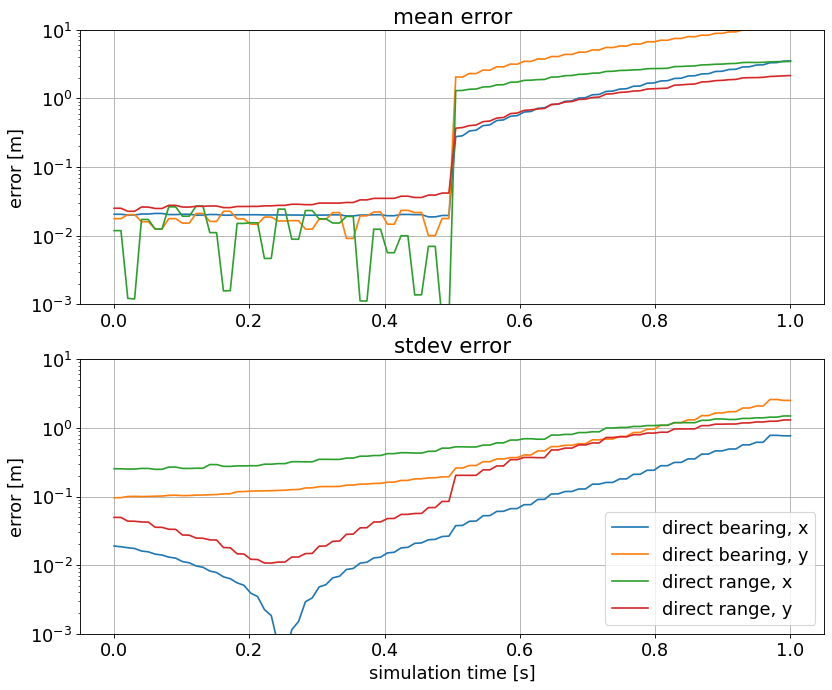

In [48]:
fig, ax = plt.subplots(2,1, figsize=(12, 10), dpi=80)
ax[0].semilogy(t,np.abs(np.mean(re_rxL_db_x, axis=1)))
ax[0].semilogy(t,np.abs(np.mean(re_rxL_db_y, axis=1)))
ax[0].semilogy(t,np.abs(np.mean(re_rxL_dr_x, axis=1)))
ax[0].semilogy(t,np.abs(np.mean(re_rxL_dr_y, axis=1)))
#ax[0].legend(['direct bearing, x','direct bearing, y', 'direct range, x', 'direct range, y'])
ax[0].grid()
ax[0].set_title('mean error')
#ax[0].set_xlabel('simulation time [s]')
ax[0].set_ylabel('error [m]')
ax[0].set_ylim([1e-3, 1e1])
ax[1].semilogy(t,np.abs(np.std(re_rxL_db_x, axis=1)))
ax[1].semilogy(t,np.abs(np.std(re_rxL_db_y, axis=1)))
ax[1].semilogy(t,np.abs(np.std(re_rxL_dr_x, axis=1)))
ax[1].semilogy(t,np.abs(np.std(re_rxL_dr_y, axis=1)))
ax[1].legend(['direct bearing, x','direct bearing, y', 'direct range, x', 'direct range, y'])
ax[1].grid()
ax[1].set_title('stdev error')
ax[1].set_xlabel('simulation time [s]')
ax[1].set_ylabel('error [m]')
ax[1].set_ylim([1e-3, 1e1])
#plt.savefig("running.jpg" , bbox_inches='tight')
#plt.show()

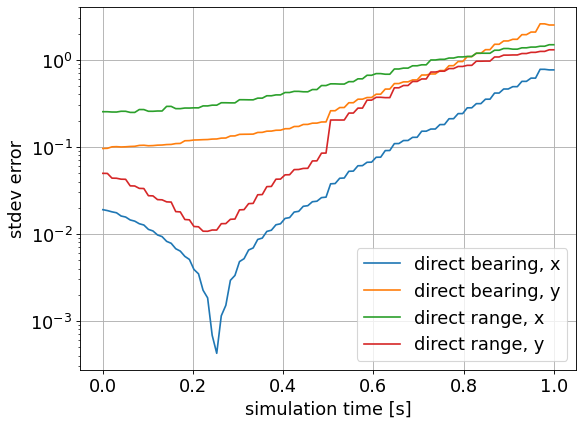

In [18]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

plt.show()

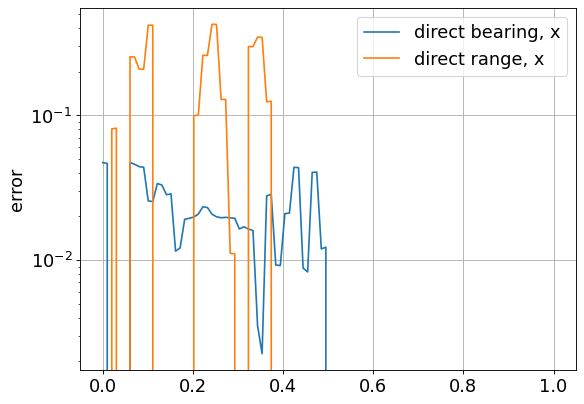

In [19]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.semilogy(t,re_rxL_db_x[:,0])
ax.semilogy(t,re_rxL_dr_x[:,0])
ax.legend(['direct bearing, x','direct range, x'])
ax.grid()
plt.ylabel('error')
plt.show()

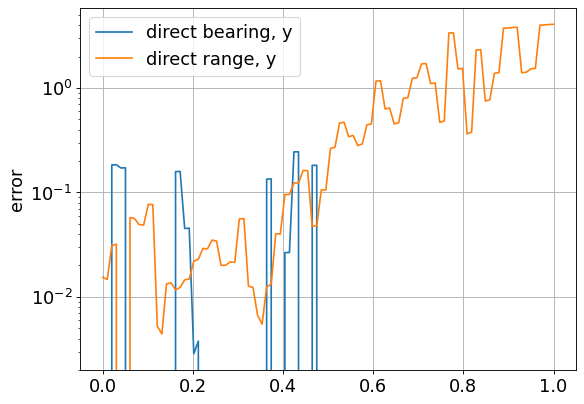

In [20]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.semilogy(t,re_rxL_db_y[:,0])
ax.semilogy(t,re_rxL_dr_y[:,0])
ax.legend(['direct bearing, y','direct range, y'])
ax.grid()
plt.ylabel('error')
plt.show()

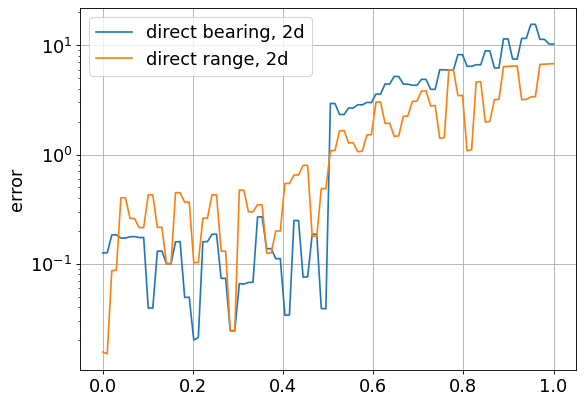

In [21]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.semilogy(t,np.sqrt(re_rxL_db_x[:,0]**2 + re_rxL_db_y[:,0]**2))
ax.semilogy(t,np.sqrt(re_rxL_dr_x[:,0]**2 + re_rxL_dr_y[:,0]**2))
ax.legend(['direct bearing, 2d','direct range, 2d'])
ax.grid()
plt.ylabel('error')
plt.show()

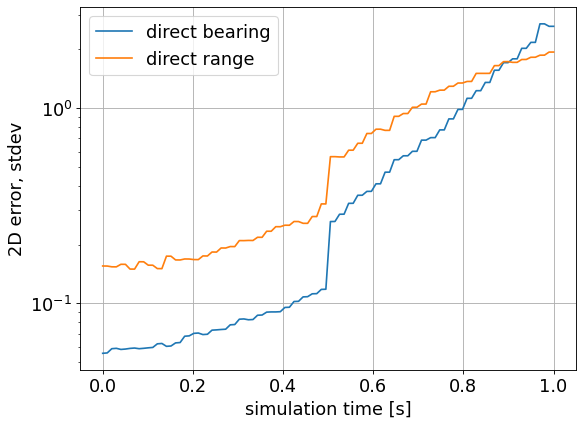

In [22]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.semilogy(t,np.std(np.sqrt(re_rxL_db_x**2 + re_rxL_db_y**2), axis=1))
ax.semilogy(t,np.std(np.sqrt(re_rxL_dr_x**2 + re_rxL_dr_y**2), axis=1))
ax.legend(['direct bearing','direct range'])
ax.grid()
plt.ylabel('2D error, stdev')
plt.xlabel('simulation time [s]')
plt.show()

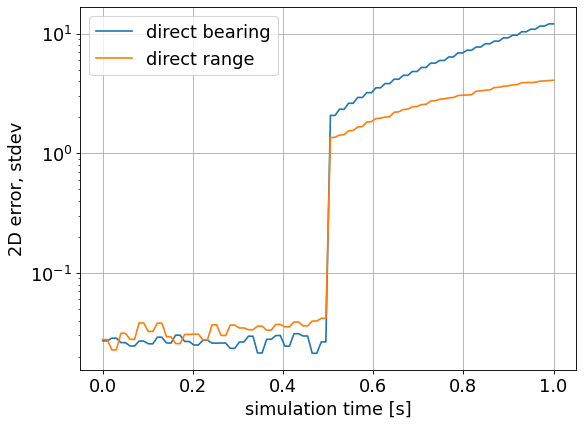

In [23]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.semilogy(t,np.sqrt(np.mean(re_rxL_db_x,axis=1)**2 + np.mean(re_rxL_db_y,axis=1)**2))
ax.semilogy(t,np.sqrt(np.mean(re_rxL_dr_x,axis=1)**2 + np.mean(re_rxL_dr_y,axis=1)**2))
ax.legend(['direct bearing','direct range'])
ax.grid()
plt.ylabel('2D error, stdev')
plt.xlabel('simulation time [s]')
plt.show()